# NBA Tracking - Sprint Speed
This notebook is a proof of concept for working with frame-by-frame tracking data and in particular, applying MLB Statcast's "sprint speed" metric ([see article](http://tangotiger.com/index.php/site/article/statcast-lab-introducing-sprint-speed)) to the players in an NBA game

In [1]:
# read in data
import json
import scipy.spatial.distance as spdist
import pandas as pd
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
nba_fn = '0021500492.json'

nba_fo = open(nba_fn)
nba = json.load(nba_fo)

The data format of NBA tracking data is a JSON file which is similar to the dictionary structure in Python. Reading the file in results in a dictionary object whose values are the game date, an ID for the game and a list of "events" each of which is a dictionary which represents (I think) the data for a given possession. See [this blog post](http://savvastjortjoglou.com/nba-play-by-play-movements.html) for more info on the structure of the tracking data

In parsing this and computing speed numbers, it was apparent that some events contain no frame data, so filter them out from a list of the events

In [3]:
game_events = [i for i in nba['events'] if len(i['moments']) != 0]
# columns for each frame of location data
mom_columns = ['team_id','player_id','x','y','z']
# metadata columns for each event
mom_attr = ['quarter','unix_ts','game_clock_sec','shot_clock_sec','extra']

Function which calculates the max distance travelled for all 30-second windows in an event, grouped by player. Also can adjust the length of the window to tweak the definition of sprint speed (e.g. 3 or 4/5 of a second instead of 1 sec)

In [4]:
def sprint_speed(frame_df,frames_window=25):
    # calculate distance moved for each player in each frame
    prev_x = frame_df.groupby(level=2).x.shift(1)
    prev_y = frame_df.groupby(level=2).y.shift(1)

    # there are some frames where the clock is stopped and people jump around a bit within events
    # filter these out by making sure distance moved is calculated only if the clock is running.
    clock_run = (frame_df.game_clock_sec != frame_df.groupby(level=2).game_clock_sec.shift(-1))
    frame_df['dist_moved'] = np.sqrt(np.square(frame_df.x - prev_x) + np.square(frame_df.y - prev_y))
    frame_df.loc[~(clock_run),'dist_moved'] = np.nan
    frame_df['speed'] = frame_df['dist_moved'] * 25

    # calculate most distance moved over 1 second window (MLB sprint speed)
    f = lambda x: x.rolling(frames_window).sum()
    spr_speed = frame_df.groupby(level=2).dist_moved.apply(f)
    max_fps = (pd.DataFrame(spr_speed.groupby(level=2).max() * (25.0 / frames_window))
                .assign(event = e_i)
                .join(player_df)
                .reset_index()
                .set_index(['event','player_id']))
    return max_fps

Loop through the events and parse the moment data, calculate the best sprint speed over a 1 second window, and concatenate that data to a dataframe (this takes a while and will print 400ish lines as it iterates) 

In [5]:
e_i = 0
ev = game_events[0] 

In [6]:
ev_frames = pd.DataFrame()
ev_moments = [i for i in ev['moments']]
ev_players = ev['home']['players'] + ev['visitor']['players']
player_df = pd.DataFrame(ev_players).set_index('playerid')

In [7]:
len(ev_moments)

150

In [8]:
poss_data = []
print e_i
ev_frames = pd.DataFrame()
ev_moments = [i for i in ev['moments']]
ev_players = ev['home']['players'] + ev['visitor']['players']
player_df = pd.DataFrame(ev_players).set_index('playerid')
for m_i, ev_m in enumerate(ev_moments):
    ev_player_m = ev_m[5]
    attr_vals = ev_m[:5]
    ev_mdf = pd.DataFrame(ev_player_m,columns=mom_columns)
    ev_m_attrs = pd.DataFrame(map(lambda x: attr_vals,ev_player_m),columns=mom_attr)
    ev_m_data = pd.concat([ev_mdf,ev_m_attrs],axis=1)
    # ev_m_data['ev_moment'] = '_'.join((str(e_i),str(m_i)))
    ev_m_data['event'] = e_i
    ev_m_data['moment'] = m_i
    poss_data.append(ev_m_data)

0


In [9]:
poss_df = pd.concat(poss_data).reset_index(drop=True)

In [10]:
poss_df[['x','y']].describe()

,x,y
count,1650.000000,1650.000000
mean,14.621370,23.697467
std,8.815613,10.438266
min,2.244680,2.481390
25%,7.304360,16.887530
50%,12.952660,22.795820
75%,18.740695,32.744898
max,35.373030,45.127340


In [11]:
poss_df.head()

,team_id,player_id,x,y,z,quarter,unix_ts,game_clock_sec,shot_clock_sec,extra,event,moment
0,-1,-1,23.42540,45.12734,3.64299,1,1451695252003,711.26,11.99,None,0,0
1,1610612761,2449,19.08811,13.91147,0.00000,1,1451695252003,711.26,11.99,None,0,0
2,1610612761,201960,10.11935,13.54703,0.00000,1,1451695252003,711.26,11.99,None,0,0
3,1610612761,200768,20.81838,44.51006,0.00000,1,1451695252003,711.26,11.99,None,0,0
4,1610612761,201942,14.16535,38.79570,0.00000,1,1451695252003,711.26,11.99,None,0,0


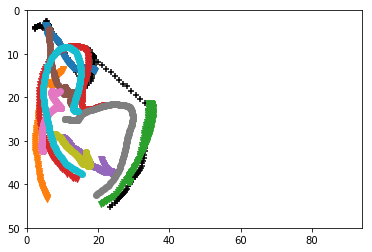

In [12]:
fig, ax = plt.subplots()
fig,
ax.axis([0,94,50,0])
for player in poss_df['player_id'].unique():
    player_vals = poss_df.query('player_id == @player')
    if player == -1:
        ax.scatter(x=player_vals['x'],y=player_vals['y'],marker='+',c='black')
    elif player_vals['team_id'].iloc[0] == 1610612761:
        ax.scatter(x=player_vals['x'],y=player_vals['y'],marker='v')
    else:
        ax.scatter(x=player_vals['x'],y=player_vals['y'],marker='o')

In [13]:
non_ball = poss_df.team_id != -1

<class 'matplotlib.figure.Figure'>


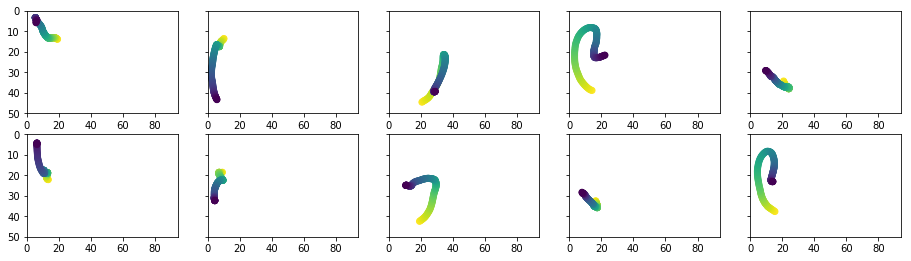

In [14]:
poss_team_players = poss_df.loc[non_ball].groupby('team_id').player_id.unique()
poss_teams = poss_team_players.index
fig, axes = plt.subplots(2,5,sharey=True, figsize=[15.66,4.16])
print type(fig)
#fig.f
for t_i, axrow in enumerate(axes):
    team = poss_teams[t_i]
    players = poss_team_players.loc[team]
    for p_i, ax in enumerate(axrow):
        player = players[p_i]
        ax.axis([0,94,50,0])
        player_vals = poss_df.query('player_id == @player')
        ax.scatter(x=player_vals['x'],
                   y=player_vals['y'],
                   marker='o',
                   c=player_vals['shot_clock_sec'])

In [15]:
def court_distance(current, prev):
    delta_x = current['x'] - prev['x']
    delta_y = current['y'] - prev['y']
    return np.sqrt(np.square(delta_x) + np.square(delta_y))

In [16]:
poss_df['dist_prev_frame'] = court_distance(poss_df,poss_df.groupby('player_id').shift(1))

In [17]:
poss_df['speed_fs'] = poss_df['dist_prev_frame'] / 0.25

In [32]:
poss_df['smooth_speed'] = (poss_df.groupby('player_id')
                                  .rolling(5, center=True)
                                  .speed_fs
                                  .mean()
                                  .reset_index(0,drop=True)
                            )

In [33]:
has_speed_vals = (poss_df[['smooth_speed','speed_fs']].isnull().sum(axis=1) == 0)

<class 'matplotlib.figure.Figure'>


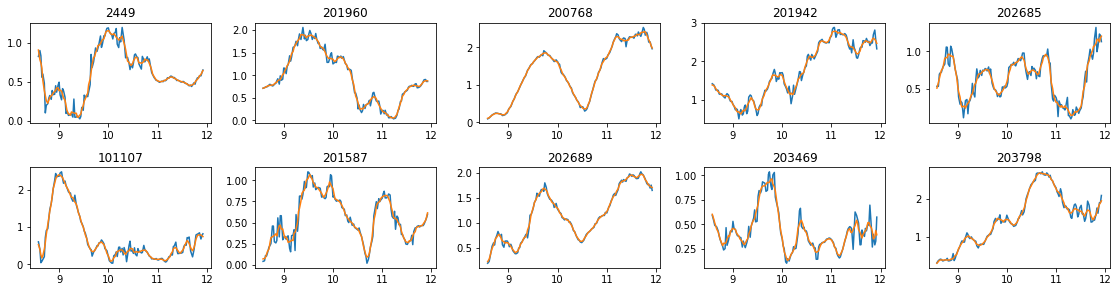

In [50]:
poss_team_players = poss_df.loc[non_ball & has_speed_vals].groupby('team_id').player_id.unique()
poss_teams = poss_team_players.index
fig, axes = plt.subplots(2,5, figsize=[15.66,4.16])
print type(fig)
for t_i, axrow in enumerate(axes):
    team = poss_teams[t_i]
    players = poss_team_players.loc[team]
    for p_i, ax in enumerate(axrow):
        player = players[p_i]
        player_idx = poss_df.player_id == player
        player_vals = poss_df.loc[non_ball & has_speed_vals & player_idx]
        ax.plot(player_vals['shot_clock_sec'],
                   player_vals['speed_fs'])
        ax.plot(player_vals['shot_clock_sec'],
                   player_vals['smooth_speed'])
        ax.set_title(str(player))
fig.tight_layout()

In [62]:
poss_df['low_speed_frame'] = (poss_df['smooth_speed'] < 0.1)

In [82]:
poss_df['prev_diff_speed'] = (poss_df['low_speed_frame'] != (poss_df.groupby('player_id').low_speed_frame.shift(1)))
poss_df['period_group'] = poss_df.groupby('player_id').prev_diff_speed.cumsum()
poss_df['period_lowspeed'] = poss_df.groupby(['player_id','period_group']).low_speed_frame.transform('sum')
#poss_df['period_consec_max'] = poss_df.groupby(['player_id','period_group']).consec_low_speed.max()
poss_df['cut_frame'] = ((poss_df['period_lowspeed'] > 5) & 
                        (poss_df['prev_diff_speed'] | 
                              poss_df.groupby(['player_id']).prev_diff_speed.shift(-1))
                        )
#poss_df['cut_frame'] = poss_df['next_diff_speed'] & (poss_df['low_speed_frame'] == poss_df.groupby('player_id').low_speed_frame.shift(1))

<class 'matplotlib.figure.Figure'>


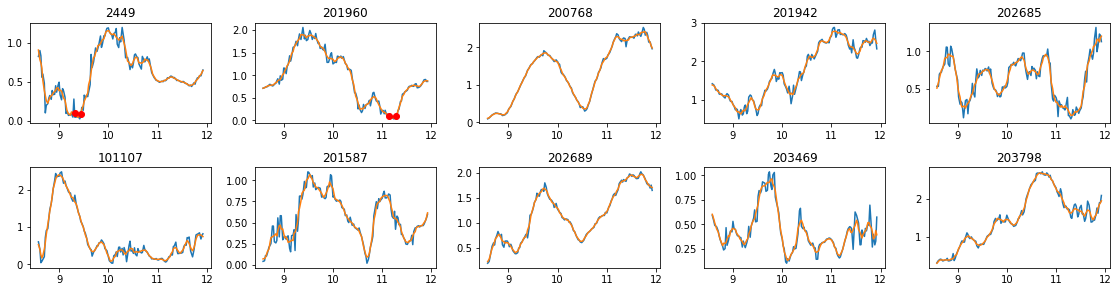

In [83]:
poss_team_players = poss_df.loc[non_ball & has_speed_vals].groupby('team_id').player_id.unique()
poss_teams = poss_team_players.index
fig, axes = plt.subplots(2,5, figsize=[15.66,4.16])
print type(fig)
for t_i, axrow in enumerate(axes):
    team = poss_teams[t_i]
    players = poss_team_players.loc[team]
    for p_i, ax in enumerate(axrow):
        player = players[p_i]
        player_idx = poss_df.player_id == player
        player_vals = poss_df.loc[non_ball & has_speed_vals & player_idx]
        cut_frames = player_vals.loc[player_vals.cut_frame]
        ax.plot(player_vals['shot_clock_sec'],
                   player_vals['speed_fs'])
        ax.plot(player_vals['shot_clock_sec'],
                   player_vals['smooth_speed'])
        ax.plot(cut_frames['shot_clock_sec'],
                   cut_frames['smooth_speed'],
                   'ro')
        ax.set_title(str(player))
fig.tight_layout()